In [1]:
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class Bandit:
    def __init__(self, mu: float, sigma: float):
        self._mu = mu
        self._sigma = sigma

        self._Q_est = 0
        self._N = 0

    def pull(self) -> float:
        return np.random.randn() * self._sigma + self._mu

    def update(self, r: float, mode: str):
        alpha = 0
        if mode == "sample_avg":
            self._N += 1
            alpha = 1 / self._N
        else:
            alpha = 0.1
        self._Q_est += (r - self._Q_est) * alpha

    def random_walk(self, walk_std: float = 0.01):
        self._mu += np.random.normal(loc=0.0, scale=walk_std)

    @property
    def true_value(self):
        return self._mu

    @property
    def Q(self):
        return self._Q_est

In [3]:
def single_run(
    bandits: List[Bandit], n_steps: int, eps: float, mode: str
) -> Tuple[np.ndarray, np.ndarray]:

    rewards = np.zeros(n_steps)
    optimal = np.zeros(n_steps)

    for i in range(n_steps):
        cur_optimal_bandit = int(np.argmax([b.true_value for b in bandits]))
        if np.random.rand() < eps:
            bandit = np.random.choice(np.arange(len(bandits)))
        else:
            bandit = np.argmax([b.Q for b in bandits])

        reward = bandits[int(bandit)].pull()
        bandits[int(bandit)].update(reward, mode)

        for b in bandits:
            b.random_walk()

        rewards[i] = reward
        optimal[i] = 1 if int(bandit) == cur_optimal_bandit else 0

    return rewards, optimal

In [4]:
def run_experiment(
    true_means: np.ndarray,
    true_sigmas: np.ndarray,
    n_runs: int,
    n_steps: int,
    alpha_mode: str = "constant",
    eps: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:

    if alpha_mode not in ["sample_avg", "constant"]:
        raise Exception(
            f"Sorry expected alpha_mode to be either 'constant'/'sample_avg'. Found alpha_mode to be '{alpha_mode}.'"
        )

    all_rewards = np.zeros((n_runs, n_steps))
    all_optimals = np.zeros((n_runs, n_steps))

    for run in range(n_runs):
        bandits = [Bandit(mu, sigma) for mu, sigma in zip(true_means, true_sigmas)]
        rewards, optimals = single_run(
            bandits=bandits, n_steps=n_steps, eps=eps, mode=alpha_mode
        )
        all_rewards[run] = rewards
        all_optimals[run] = optimals

    return all_rewards.mean(axis=0), all_optimals.mean(axis=0)

In [5]:
K = 10
TRUE_MEANS = np.random.randn(K)
TRUE_SIGMAS = np.random.rand(K)
N_STEPS = 10_000
N_RUNS = 2000

In [7]:
exp_r_1, exp_o_1 = run_experiment(
    true_means=TRUE_MEANS,
    true_sigmas=TRUE_SIGMAS,
    n_runs=N_RUNS,
    n_steps=N_STEPS,
    alpha_mode="constant",
    eps=0.1,
)


# plt.figure(figsize=(15, 8))
# plt.subplot(2, 1, 1)
# plt.plot(exp_r_1)
# plt.ylabel("Average Rewards")
# plt.subplot(2, 1, 2)
# plt.plot(exp_o_1 * 100)
# plt.ylabel("% Optimal action")
# plt.xlabel("Steps")
# plt.tight_layout()
# plt.show()

In [8]:
exp_r_2, exp_o_2 = run_experiment(
    true_means=TRUE_MEANS,
    true_sigmas=TRUE_SIGMAS,
    n_runs=N_RUNS,
    n_steps=N_STEPS,
    alpha_mode="sample_avg",
    eps=0.1,
)


# plt.figure(figsize=(15, 8))
# plt.subplot(2, 1, 1)
# plt.plot(exp_r_2)
# plt.ylabel("Average Rewards")
# plt.subplot(2, 1, 2)
# plt.plot(exp_o_2 * 100)
# plt.ylabel("% Optimal action")
# plt.xlabel("Steps")
# plt.tight_layout()
# plt.show()

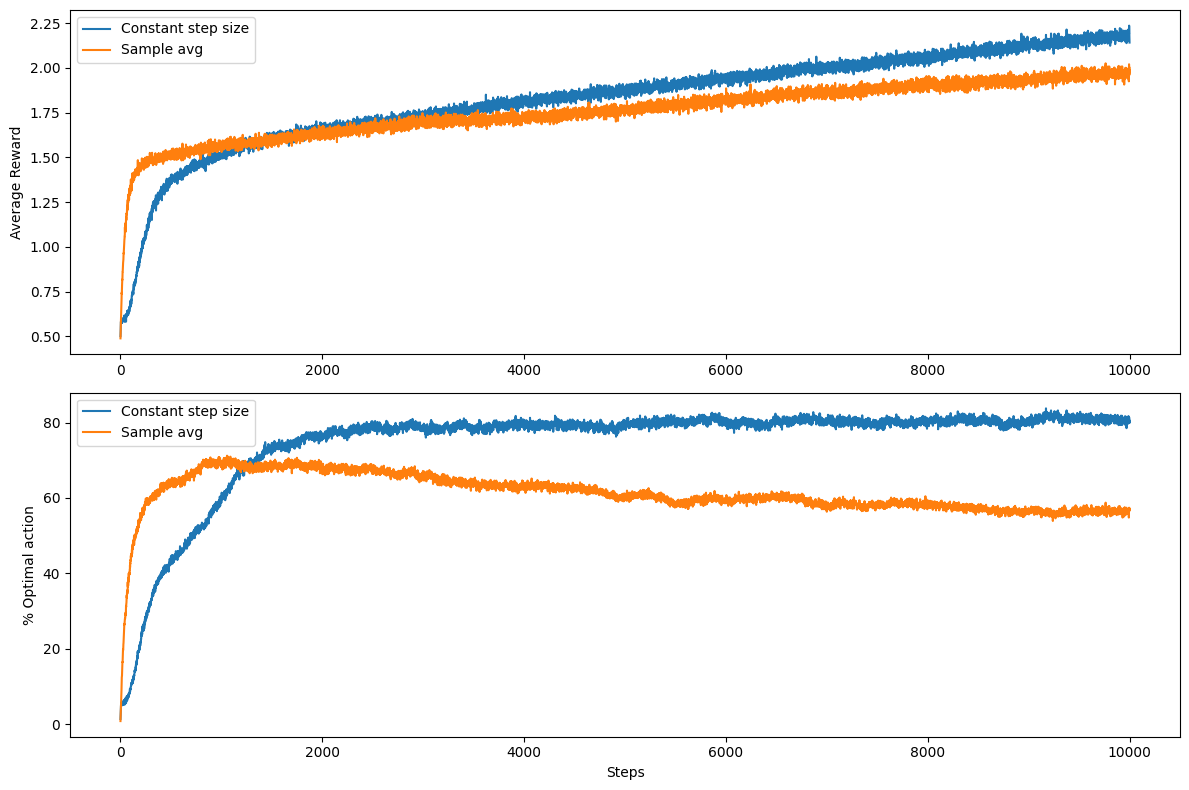

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(exp_r_1, label="Constant step size")
plt.plot(exp_r_2, label="Sample avg")
plt.ylabel("Average Reward")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(exp_o_1 * 100, label="Constant step size")
plt.plot(exp_o_2 * 100, label="Sample avg")
plt.ylabel("% Optimal action")
plt.xlabel("Steps")
plt.legend()
plt.tight_layout()
plt.show()